# Preprocessing files 


In [5]:
#!python3 -m pip install python_speech_features # Install PSF specifically on python3.
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
from python_speech_features import mfcc
import matplotlib.pyplot as plt
import tracemalloc
from SerialTriggerDecoder import SerialTriggerDecoder

tracemalloc.start() # Enable memory profiling

#

## Find files, and list structure

In [6]:

# OS walk through the directory to find the files
#root_dir = '//uni.au.dk/dfs/Tech_EarEEG/Students/Msc2022_BCM_AkselStark'
root_dir = 'bcm_activity_dataset'
data = [] # Empty list to store all hdf5 files in the directory

for subdir, dirs, files in sorted(os.walk(root_dir)):
    for file in files:
        if "hdf5" in file:
            print("\n\n\n")
            # Load the hdf5 file, and append to the list
            print(file)
            
            data.append(h5py.File(os.path.join(subdir, file), 'r'))
            
            print(f'{subdir}/{file}') # Print the filename
            keylist = list(data[0].keys())
            print( keylist) # Print the keys of the hdf5 file
for i,j in enumerate(data):
    print("\n\n\n")
    print(f'Index of the hdf5 file: {i}') # Print the index of the hdf5 file
    for key in keylist:
        print(key)
        try: # Try to print the keys. If it fails, print the data
            print(f"    {list(data[i][key].keys())}")
        except:
            print("    No subkeys")
            print(f"    {np.array(data[i][key])}")
            s = data[i][key]
                        
                        
pass
            





2022-09-20_14-58-39.hdf5
bcm_activity_dataset/2022-09-20_14-58-39.hdf5
['DAQ970A', 'streaminfo']




2022-09-20_15-57-37.hdf5
bcm_activity_dataset/2022-09-20_15-57-37.hdf5
['DAQ970A', 'streaminfo']




2022-09-20_15-18-27.hdf5
bcm_activity_dataset/2022-09-20_15-18-27.hdf5
['DAQ970A', 'streaminfo']




2022-09-20_15-38-11.hdf5
bcm_activity_dataset/2022-09-20_15-38-11.hdf5
['DAQ970A', 'streaminfo']




Index of the hdf5 file: 0
DAQ970A
    ['data', 'labels']
streaminfo
    No subkeys
    [(4, b'cf_float32', 1695.5818, b'5125-240-002', b'DAQ970A', 50000, b'DAQ970A_TCPIP_192_168_56_100', b'Generic')]




Index of the hdf5 file: 1
DAQ970A
    ['data', 'labels']
streaminfo
    No subkeys
    [(4, b'cf_float32', 5233.929, b'5125-240-002', b'DAQ970A', 50000, b'DAQ970A_TCPIP_192_168_56_100', b'Generic')]




Index of the hdf5 file: 2
DAQ970A
    ['data', 'labels']
streaminfo
    No subkeys
    [(4, b'cf_float32', 2884.1384, b'5125-240-002', b'DAQ970A', 50000, b'DAQ970A_TCPIP_192_168_56_100'

## Load data, and labels/triggers

In [7]:
# Load data

print(f'Memory usage: {tracemalloc.get_traced_memory()[0]/1000000} MB\n')
data_bcm = []
labels_bcm = []
for file in data:
    print(f"data    {data}")
    data_full = np.array(data[0]['DAQ970A']['data'])
    data_bcm.append(data_full[:,0])
    data_bcm.append(data_full[:,1])
    print(f'Memory usage: {tracemalloc.get_traced_memory()[0]/1000000} MB\n')

    print(f"Labels    {data}")
    labels_bcm.append(data[0]['DAQ970A']['data'][:,3])
    print(f'Memory usage: {tracemalloc.get_traced_memory()[0]/1000000} MB\n')

pass

Memory usage: 3920.542459 MB

data    [<HDF5 file "2022-09-20_14-58-39.hdf5" (mode r)>, <HDF5 file "2022-09-20_15-57-37.hdf5" (mode r)>, <HDF5 file "2022-09-20_15-18-27.hdf5" (mode r)>, <HDF5 file "2022-09-20_15-38-11.hdf5" (mode r)>]
Memory usage: 784.537558 MB

Labels    [<HDF5 file "2022-09-20_14-58-39.hdf5" (mode r)>, <HDF5 file "2022-09-20_15-57-37.hdf5" (mode r)>, <HDF5 file "2022-09-20_15-18-27.hdf5" (mode r)>, <HDF5 file "2022-09-20_15-38-11.hdf5" (mode r)>]
Memory usage: 980.538694 MB

data    [<HDF5 file "2022-09-20_14-58-39.hdf5" (mode r)>, <HDF5 file "2022-09-20_15-57-37.hdf5" (mode r)>, <HDF5 file "2022-09-20_15-18-27.hdf5" (mode r)>, <HDF5 file "2022-09-20_15-38-11.hdf5" (mode r)>]
Memory usage: 1764.540254 MB

Labels    [<HDF5 file "2022-09-20_14-58-39.hdf5" (mode r)>, <HDF5 file "2022-09-20_15-57-37.hdf5" (mode r)>, <HDF5 file "2022-09-20_15-18-27.hdf5" (mode r)>, <HDF5 file "2022-09-20_15-38-11.hdf5" (mode r)>]
Memory usage: 1960.540975 MB

data    [<HDF5 file "2022-09

## Plot cepstrum


In [8]:
# Plot spectrogram
#plt.pcolormesh(t[0:20], f, np.log(spectrogram_list[segment_index]),shading='auto')
#plt.pcolormesh(np.log(data_mfcc[4][20605:20610,1:].transpose()),shading='auto')
def plot_mfcc(data_mfcc):
    plt.pcolormesh((data_mfcc.transpose()),shading='auto')
    plt.ylabel('Cepstrum Coefficients')
    plt.xlabel('Time [sec]')
    plt.show()

# Create the labels

## Plot and test the manchester encoding

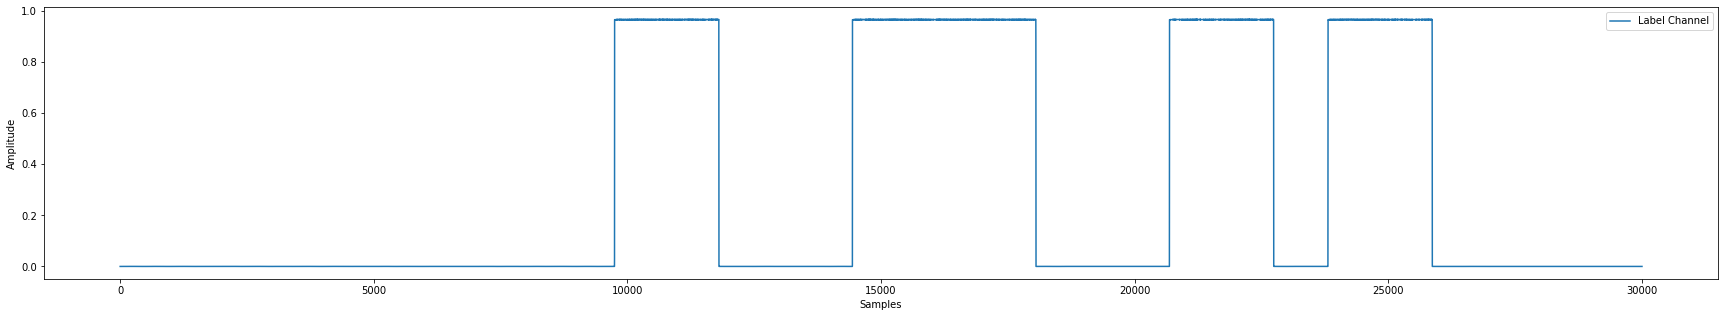

In [9]:
# Doesn't work right now

# Plot the label channel
pos = 0

fig = plt.figure(figsize=(30, 5))

jump = 2 # Measured: clock of manchester encoding
len = 60000
segment = labels_bcm[0][pos:pos+len][0::jump]

plt.plot(segment, label='Label Channel')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

plt.grid(which = 'minor')

#decode signal from manchester encoding
def manchester_decode(data):
    manchester_decoded = []
    for i in range(0,data.shape[0]-1,2):
        if data[i] == 0 and data[i+1] == 1:
            manchester_decoded.append(0)
        elif data[i] == 1 and data[i+1] == 0:
            manchester_decoded.append(1)
        else:
            manchester_decoded.append(8888) #error
    return manchester_decoded
    

#print(np.rint(segment))
#print(manchester_decode(np.rint(segment)))
plt.show()

## Find the sections, and label them

In [10]:
# Creates a list of the positions of the triggers (and plot them for verification)

last_decoded = -500000
label_index_list = [] # List of the indices of the labels
for i, j in enumerate(np.rint(labels_bcm[1])):
    
    if int(j) and (i > last_decoded+50000*8):
        #print(manchester_decode(np.rint(labels_bcm[0][i-900:i+100000][0::2480])))
        print(f"i: {i}")
        print(f"Time: {i/50000} s")
        last_decoded = i
        
        label_index_list.append(i)
        ''' # Plot
        fig = plt.figure(figsize=(30, 5))
        plt.plot(labels_bcm[1][i-900:i+50000], label='Label Channel')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.legend()

        plt.grid(which = 'minor')
        plt.show()
        '''
    


i: 19492
Time: 0.38984 s
i: 519489
Time: 10.38978 s
i: 1019486
Time: 20.38972 s
i: 1519483
Time: 30.38966 s
i: 2019481
Time: 40.38962 s
i: 2519478
Time: 50.38956 s
i: 3019475
Time: 60.3895 s
i: 3519472
Time: 70.38944 s
i: 4019470
Time: 80.3894 s
i: 4519467
Time: 90.38934 s
i: 5020452
Time: 100.40904 s
i: 5520449
Time: 110.40898 s
i: 6020446
Time: 120.40892 s
i: 6520443
Time: 130.40886 s
i: 7020440
Time: 140.4088 s
i: 7520438
Time: 150.40876 s
i: 8020435
Time: 160.4087 s
i: 8520432
Time: 170.40864 s
i: 9020429
Time: 180.40858 s
i: 9520427
Time: 190.40854 s
i: 10022045
Time: 200.4409 s
i: 10522042
Time: 210.44084 s
i: 11022039
Time: 220.44078 s
i: 11522036
Time: 230.44072 s
i: 12022033
Time: 240.44066 s
i: 12522031
Time: 250.44062 s
i: 13022028
Time: 260.44056 s
i: 13522025
Time: 270.4405 s
i: 14022022
Time: 280.44044 s
i: 14522019
Time: 290.44038 s
i: 15023764
Time: 300.47528 s
i: 15523762
Time: 310.47524 s
i: 16009096
Time: 320.18192 s
i: 16523756
Time: 330.47512 s
i: 17023753
Time: 34

In [11]:
# Make a list of the labels for the triggers

index_labels = [] # A list of labels for the indexes in label_index_list

for i in range(6):
    index_labels.extend([0,0,0,1,1,1,2,2,2,-1])

for i in range(18): index_labels.append(3)
index_labels.append(-1)

for i in range(18): index_labels.append(4)
index_labels.append(-1)

## Concatenate the data from each class, calculate the mfcc's and save to 5 files (one for each class)

In [12]:
# Add the sections to 5 lists corresponding to the 5 different labels/classes
''' 
Classes:
    Breathing: 0
    Snoring: 1
    Hold_breath: 2
    Chewing: 3
    Talking: 4
'''
fs = 50000
nested_class_list = [[],[],[],[],[]]


for datastream in data_bcm: # Loop through the data 
    for i, j in enumerate(label_index_list):
        if index_labels[i]>=0:
            nested_class_list[index_labels[i]].append(datastream[j:j+fs*10]) # Append 
            

# Concatenate the arrays, calc mfccs and save them to files
for i, j in enumerate(nested_class_list):
    stacked_array = np.hstack(j)
    
    data_mfcc = mfcc(stacked_array, samplerate = fs, nfft = 1600, winlen=0.032, winstep=0.032, numcep=16) # Sample rate is important when using mel scale
    
    np.save(f'data/bcm/{i}.npy', data_mfcc)
    